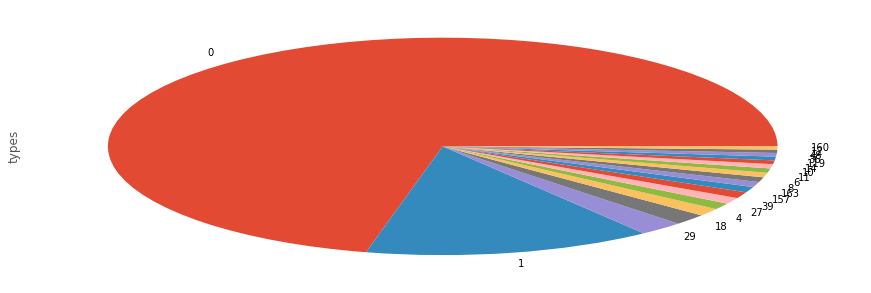

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
import matplotlib
import os
%matplotlib inline


plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (15, 5)  # Размер картинок
df_data = pd.read_hdf('df_data.h5')


from PIL import Image,ImageOps

def image_ready(path:"...\\image.PNG" = "String", type:" RGB or L" = "L", size:"pixel typle" =(28,28)):

    """"will return data in format network needs"""

    image = Image.open(path).convert(type).resize(size)
    inverted_image = ImageOps.invert(image)
    matplotlib.pyplot.imshow(inverted_image, cmap='Greys', interpolation = 'None')

    #маштабировать и сместить входные значения в пределах от 0.01 - 1.00  (любое значение в пределах 255 / 255.0 * 0.99) + 0.01)
    return (np.asfarray(inverted_image.getdata())/ 255.0 * 0.99) + 0.01 # -> asfarray конвертирует массив в float
    
    
#df_data['types'].value_counts() #- узнать количество типов
#df_data['lengths'].mean() #- показать среднее значение
df_data['types'].value_counts().plot.pie() #- нарисовать диаграмму

def render(*array:"lists of array", frequency:'Hz'= 1, colors=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']):
    print("function 'render' in progress \n")
    #возвращает цвета из массива colors, когда кончатся стандартные цвета, будет генерировать случайные
    def get_color():
        for color in colors:
            yield color
    #экземпляр класса get_color
    color_buffer = get_color()

    for n, y in enumerate(array):
        #использует базовые цвета в наличии(colors), если заканчиваются, генерирует случайные
        if n < len(colors):
            color = next(color_buffer)        
        else:
            color = (np.random.randint(255, size=(1, 3))/255).flat

        x  = np.linspace(0, frequency*len(y), len(y), endpoint=False)
        plt.plot(x, y, color=color, marker ='')

    plt.show()

# Add ops to save and restore all the variables.
# saver = tf.train.Saver()

# save_path = saver.save(sess, r"C:\Users\o.zaitsev\Source\Repos\neuralNetwork\Heart-In\model.ckpt")
# print("Model saved in path: %s" % save_path)

#saver.restore(sess, r"C:\Users\o.zaitsev\Source\Repos\neuralNetwork\Heart-In\model.ckpt")
# print("Model restored.")

In [128]:
#нормализовать данные normalize(data, axis=0, norm='max')
from sklearn.preprocessing import normalize

#исправляет данные Y, допустим [1,88,2334,1,88] исправит на [0, 1, 2, 0, 1]
def y_renamer(array:"dtype='int32'", RNN_data = False)->"исправляет данные разметки":
    
    df = pd.DataFrame(data= array, columns=["types"])    
    df_types = pd.DataFrame(data= df['types'].value_counts(), columns=["types"])
    
    print("num_classes :", len(df['types'].value_counts()))
    
    for type_number, i in enumerate(df_types.index):    
        df.loc[df.types == i, 'types'] = type_number
    
    if RNN_data:
        #[[0,0,0,1],[1,0,0,0]...]
        print("RNN_data")
        return df
    else:
        #[11,1,1,1,3,3,32,2,2,2...]
        return df.get_values().reshape(-1)



#сокращения
x_data = df_data.systoles
#типы
y_true = y_renamer(df_data.types)

#разбить данные для обучения
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)


x_train = np.array([np.array(i, dtype='float32') for i in x_train.get_values()])
x_eval  = np.array([np.array(i, dtype='float32') for i in  x_eval.get_values()])

y_train = np.array(y_train, dtype='int32')
y_eval  = np.array(y_eval,  dtype='int32')

num_classes : 19


# CONVOLUTIONAL NEURAL NETWORK

In [130]:
#CONVOLUTIONAL NEURAL NETWORK
from __future__ import division, print_function, absolute_import


# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 128

# Network Parameters
num_input = 196 # systoles data input (img shape: 14*14)
num_classes = 19 # systoles total classes (0-99 digits)
dropout = 0.25 # Dropout, probability to drop a unit


# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # systoles data input is a 1-D vector of 196 features (14*14 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 1, 196, 1])

        # Convolution Layer with 16 filters and a kernel size of 4
        conv1 = tf.layers.conv2d(x, filters=16, kernel_size= [1,4], activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, pool_size=[1,2], strides = [1,2])

        # Convolution Layer with 32 filters and a kernel size of 2
        conv2 = tf.layers.conv2d(conv1, filters=32,  kernel_size= [1,2], activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, pool_size=[1,2], strides = [1,2])

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(inputs= fc1, units= 2048, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

# Build the Estimator
model = tf.estimator.Estimator(model_fn)

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': x_train}, 
                                              y= y_train, 
                                              batch_size=batch_size, 
                                              num_epochs=None, 
                                              shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': x_eval}, 
                                              y= y_eval, 
                                              batch_size=batch_size, 
                                              shuffle=False)
# Use the Estimator 'evaluate' method

e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])#95

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\oleks\\AppData\\Local\\Temp\\tmp439syfq0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002B502B87C18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\oleks\AppData\Local\Temp\tmp439syfq0

In [ ]:
import os
import threading
import logging
from collections import Counter
logging.getLogger("tensorflow").setLevel(logging.WARNING) 

print(Counter(y_eval))
for x, y in zip(x_eval, y_eval):
    
    if y != 18:
        continue
    input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': np.array([x])}, batch_size=batch_size, shuffle=False, num_epochs=1)
    # Use the Estimator 'evaluate' method
    for p in model.predict(input_fn):
        # Use the Estimator 'evaluate' method
        #print('predict :', p, 'real :', y )  
        if p == 18:
            render(x)